In [1]:
import torch
from torch import nn
import torchvision as tv
import time

In [2]:
train_ds = tv.datasets.MNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_ds = tv.datasets.MNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

100.0%


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100.0%


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100.0%


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100.0%

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [3]:
HIDDEN_SIZE = 2

In [4]:
class View(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args

  def forward(self, X):
    return X.view(-1, *self.shape)

In [5]:
encoder = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1, 1),
    nn.LeakyReLU(),
    nn.Conv2d(32, 64, 3, 2, 1),
    nn.LeakyReLU(),
    nn.Conv2d(64, 64, 3, 2, 1),
    nn.LeakyReLU(),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.LeakyReLU(),   
    nn.Flatten(),
    nn.Linear(3136, HIDDEN_SIZE)
)

In [6]:
decoder = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, 3136),
    View(64, 7, 7 ),
    nn.ConvTranspose2d(64, 64, 3, 1, 1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 64, 3, 2, 1, output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 1, 3, 1, 1),
    nn.Sigmoid()
)

In [7]:
model = nn.Sequential(
  encoder,
  decoder
)

In [8]:
X = train_ds[0][0].view(1,1,28,28)
for t in model:
  for l in t:
    X = l(X)
    print(X.shape, l)

torch.Size([1, 32, 28, 28]) Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 32, 28, 28]) LeakyReLU(negative_slope=0.01)
torch.Size([1, 64, 14, 14]) Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([1, 64, 14, 14]) LeakyReLU(negative_slope=0.01)
torch.Size([1, 64, 7, 7]) Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([1, 64, 7, 7]) LeakyReLU(negative_slope=0.01)
torch.Size([1, 64, 7, 7]) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 7, 7]) LeakyReLU(negative_slope=0.01)
torch.Size([1, 3136]) Flatten(start_dim=1, end_dim=-1)
torch.Size([1, 2]) Linear(in_features=3136, out_features=2, bias=True)
torch.Size([1, 3136]) Linear(in_features=2, out_features=3136, bias=True)
torch.Size([1, 64, 7, 7]) View()
torch.Size([1, 64, 7, 7]) ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 7, 7]) LeakyReLU(negative_slope=0.01)
torch.

In [9]:
dev = torch.device('cuda')

In [10]:
BATCH_SIZE = 256
NUM_EPOCHS = 10
model = model.to(dev)
loss = torch.nn.MSELoss()
trainer = torch.optim.Adam(model.parameters(), lr=0.0005)
dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# стандартный цикл обучения
for e in range(NUM_EPOCHS):  #  итерация по эпохам
  total_l, start = 0., time.time()  # фиксация параметра который будем выводит на печат 
  for X, _ in dl:  #  итерация по датасету
    X = X.to(dev)  #  перевод вычислительной платформы
    trainer.zero_grad() #  очистка промежуточно единицы - сбрасываем градиент оптимайзера
    X_hat = model(X) #  вычисление значениия модели
    l = loss(X_hat, X) #  вычисление потерь - сравнимаем то что модель предсказала и наше значение
    l.backward() #  вычисление промежуточной единицы - получили градиенты
    trainer.step() #  обновление весов, сделали шаг градиаентноо спуска

    total_l += l.item() 
  print("Epoch {}. Taked {:.3f}, Loss: {:.3f}".format(e, time.time() - start, total_l))

Epoch 0. Taked 18.554, Loss: 17.787
Epoch 1. Taked 17.988, Loss: 12.056
Epoch 2. Taked 17.216, Loss: 11.237
Epoch 3. Taked 18.063, Loss: 10.771
Epoch 4. Taked 17.267, Loss: 10.487
Epoch 5. Taked 17.101, Loss: 10.268
Epoch 6. Taked 16.079, Loss: 10.106
Epoch 7. Taked 17.723, Loss: 9.943
Epoch 8. Taked 17.496, Loss: 9.830
Epoch 9. Taked 17.283, Loss: 9.710


In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Restored')

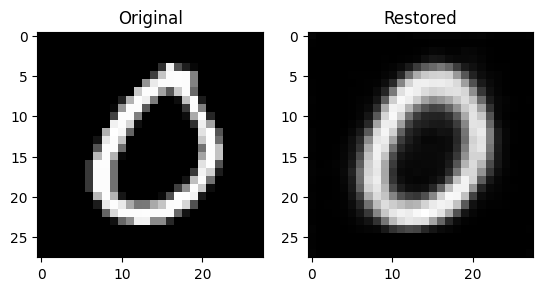

In [13]:
index = np.random.choice(len(train_ds), 1)
to_show = train_ds[index[0]][0]
restored = model(to_show.view(1,1,28,28).cuda())

plt.subplot(121)
plt.imshow(to_show.reshape(28, 28).cpu(), cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(restored.reshape(28, 28).cpu().detach(), cmap='gray')
plt.title('Restored')

Text(0.5, 1.0, 'Restored')

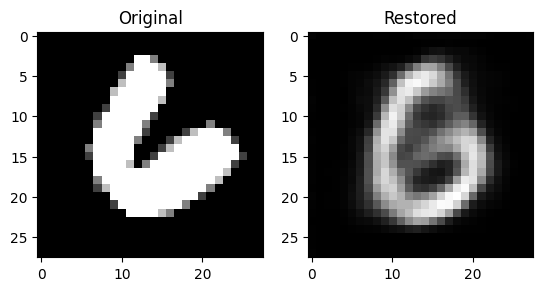

In [14]:
index = np.random.choice(len(test_ds), 1)
to_show = test_ds[index[0]][0]
restored = model(to_show.view(1,1,28,28).cuda())

plt.subplot(121)
plt.imshow(to_show.reshape(28, 28).cpu(), cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(restored.reshape(28, 28).cpu().detach(), cmap='gray')
plt.title('Restored')

In [ ]:
## Визуализация

In [16]:
values = np.zeros((len(test_ds), 2))
targets = np.zeros((len(test_ds)), dtype=int)

In [17]:
dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
model.eval()
for i, (X, t) in enumerate(dl):
  X = X.to(dev)
  encoded = encoder(X)
  values[i*BATCH_SIZE:i*BATCH_SIZE+len(X), :] = encoded.cpu().detach().numpy()
  targets[i*BATCH_SIZE:i*BATCH_SIZE+len(X)] = t.cpu().numpy()


In [19]:
values

array([[-1.5831356 , -2.94947124],
       [-2.05040526, -0.05904021],
       [-6.34441233, -3.70234466],
       ...,
       [-1.24441612, -1.92912769],
       [-1.84643197, -0.49706447],
       [-0.91186196,  0.39527974]])

[]

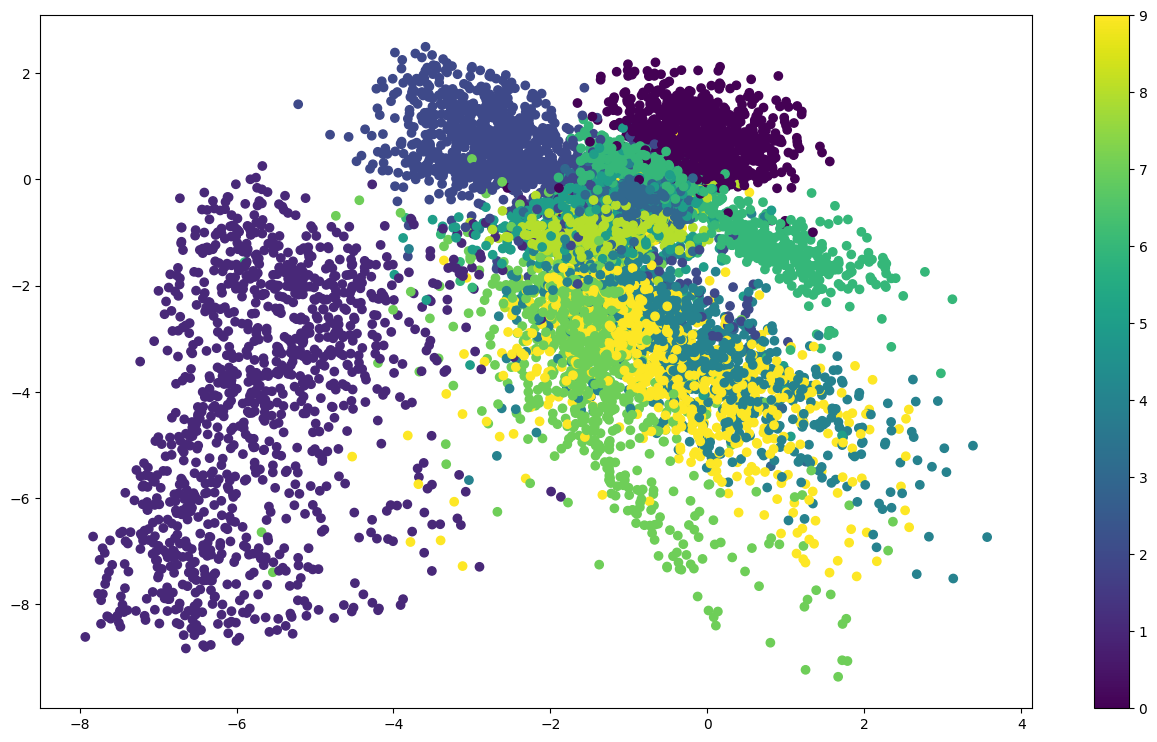

In [20]:
plt.figure(figsize=(16,9))
plt.scatter(values[:,0], values[:,1], c=targets)
plt.colorbar()
plt.plot()

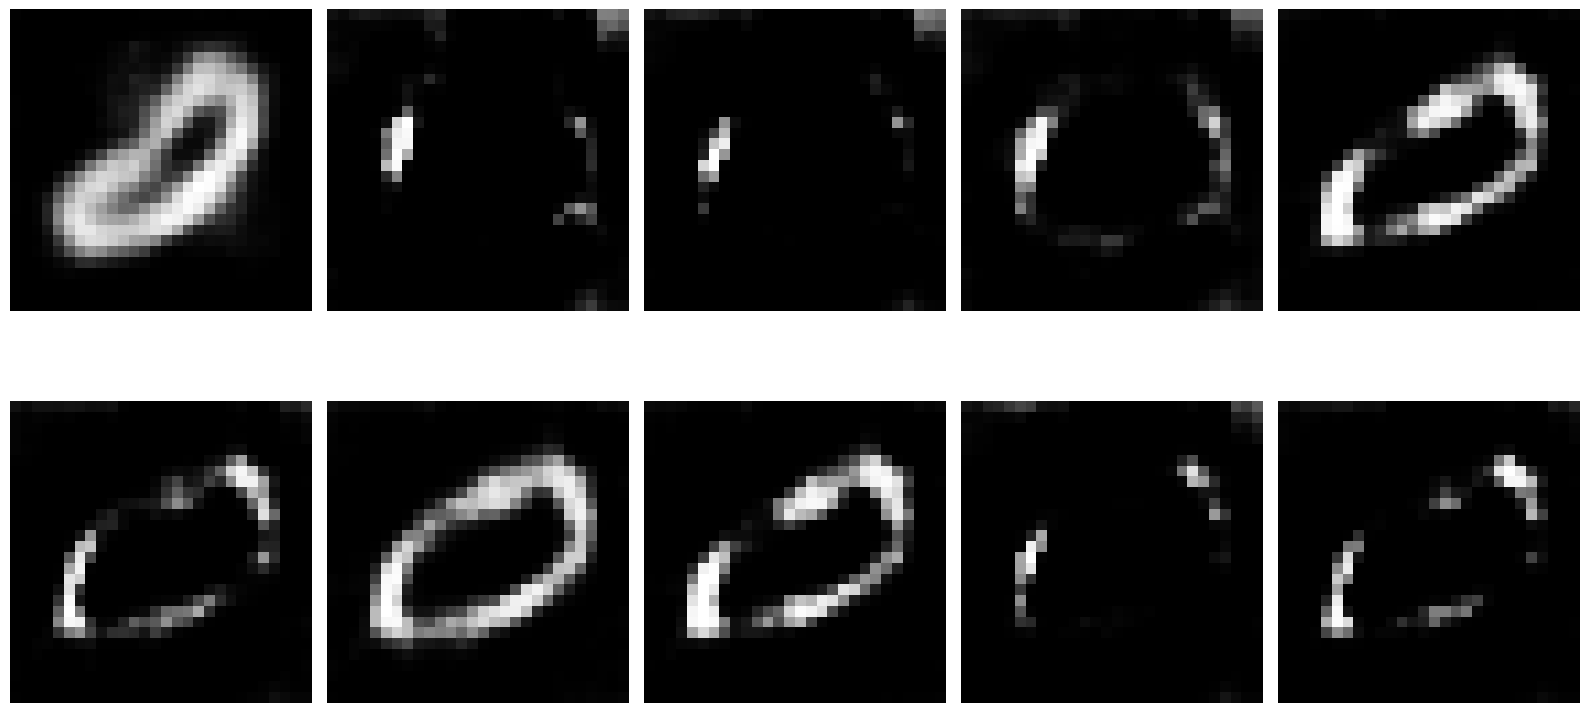

In [21]:
random_values = np.random.uniform(-2, 6, size=(10, 2))
to_restore = torch.FloatTensor(random_values).to(dev)
restored = decoder(to_restore)

plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(restored[y * 5 + x].view(28,28).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

[]

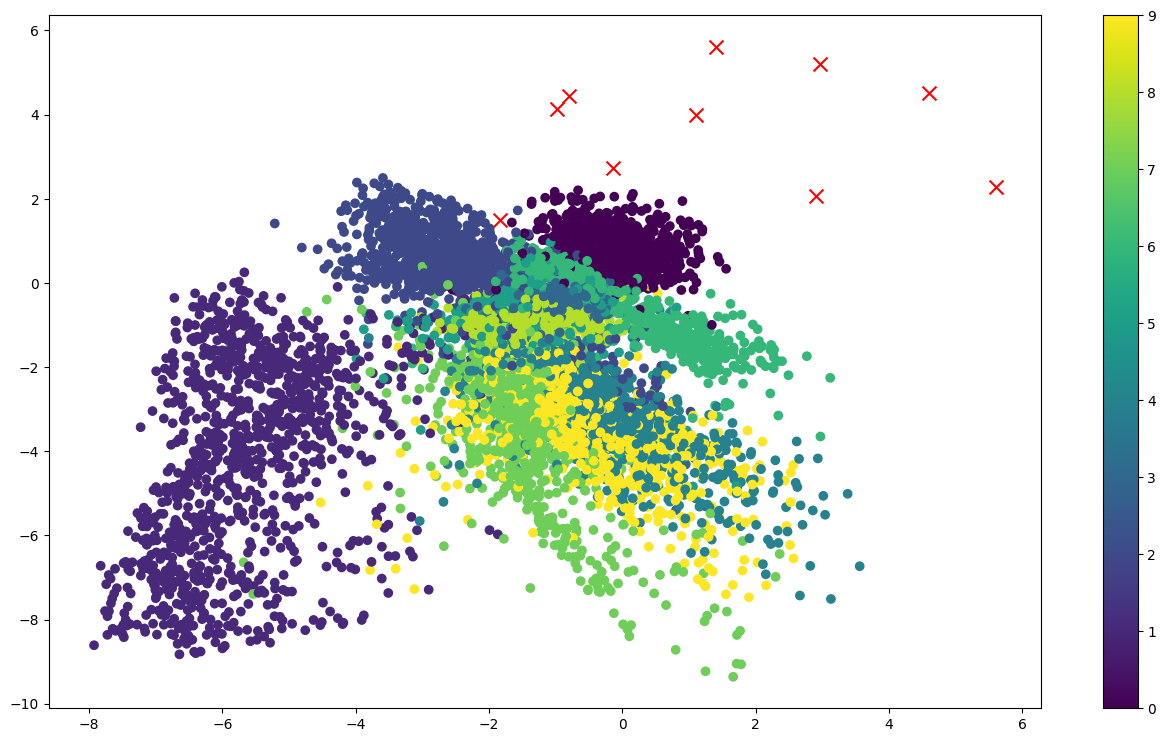

In [22]:
plt.figure(figsize=(16,9))
plt.scatter(values[:,0], values[:,1], c=targets)
plt.colorbar()
plt.scatter(random_values[:,0], random_values[:, 1], c='red', s=100, marker='x')
plt.plot()

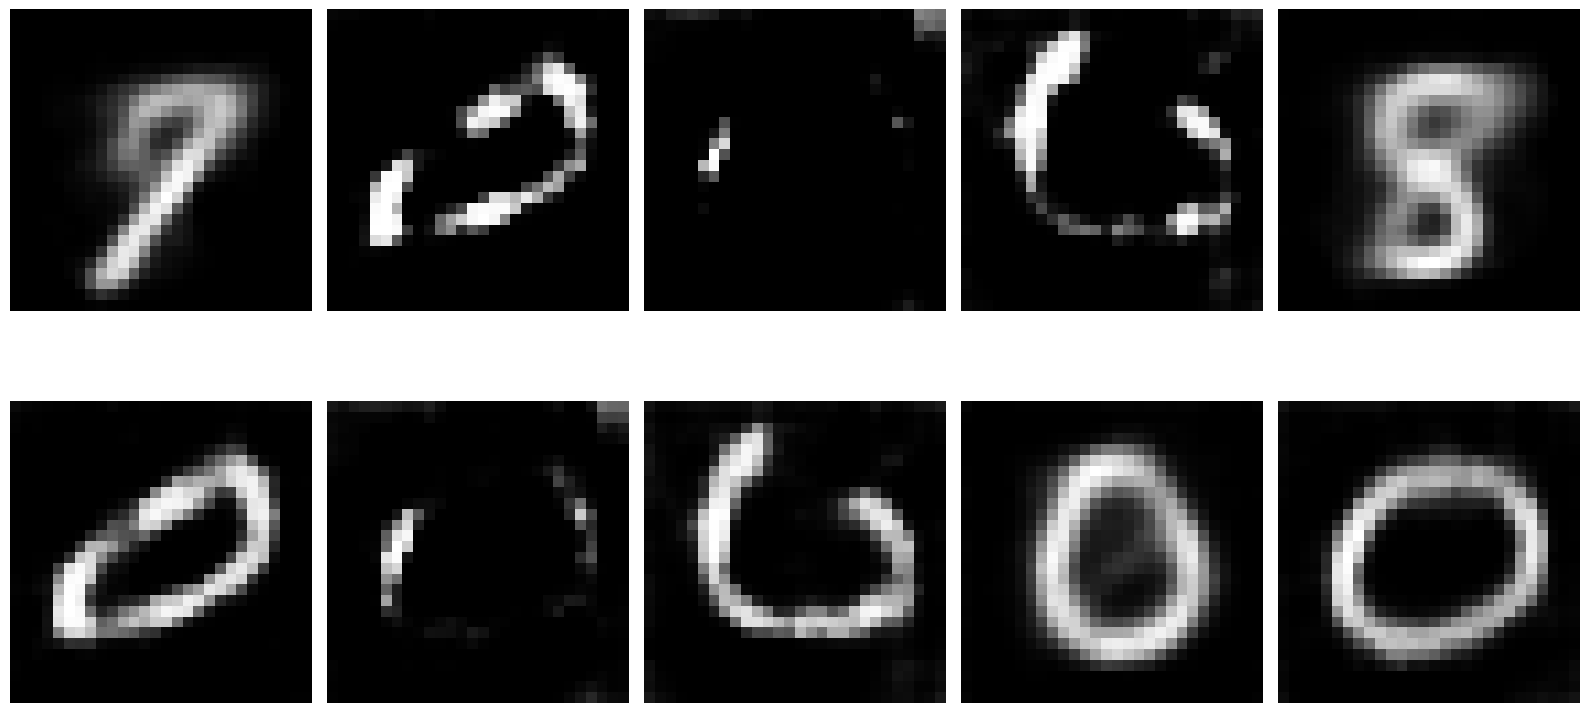

In [23]:
not_random_values = np.array([
  [-2, -2],
  [-2, 6],
  [6, 6],
  [6, -2],
  [-1, -1],
  [-1, 3],
  [3, 3],
  [3, -1],
  [0, 0],
  [1, 1]
])
to_restore = torch.FloatTensor(not_random_values).to(dev)
restored = decoder(to_restore)

plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(restored[y * 5 + x].view(28,28).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

[]

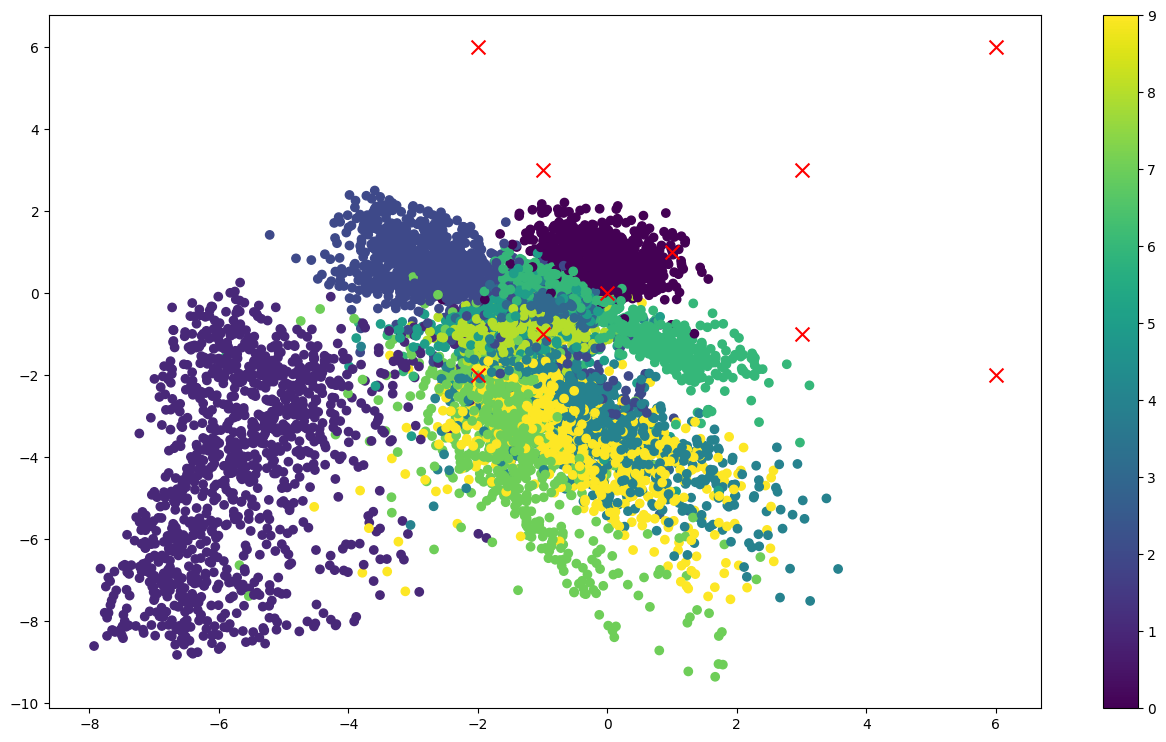

In [24]:
plt.figure(figsize=(16,9))
plt.scatter(values[:,0], values[:,1], c=targets)
plt.colorbar()
plt.scatter(not_random_values[:,0], not_random_values[:, 1], c='red', s=100, marker='x')
plt.plot()

## VAE

In [25]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = torch.nn.functional.relu(self.fc1(x))
        h = torch.nn.functional.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = torch.nn.functional.relu(self.fc4(z))
        h = torch.nn.functional.relu(self.fc5(h))
        return torch.nn.functional.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [28]:
optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [29]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dl):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dl.dataset)))

In [30]:
for epoch in range(1, 51):
    train(epoch)

====> Epoch: 1 Average loss: 261.9648
====> Epoch: 2 Average loss: 201.7131
====> Epoch: 3 Average loss: 192.2858
====> Epoch: 4 Average loss: 188.7290
====> Epoch: 5 Average loss: 181.7483
====> Epoch: 6 Average loss: 176.9870
====> Epoch: 7 Average loss: 174.2875
====> Epoch: 8 Average loss: 172.4788
====> Epoch: 9 Average loss: 170.7396
====> Epoch: 10 Average loss: 169.6985
====> Epoch: 11 Average loss: 168.7237
====> Epoch: 12 Average loss: 167.8017
====> Epoch: 13 Average loss: 166.6979
====> Epoch: 14 Average loss: 165.8994
====> Epoch: 15 Average loss: 164.6873
====> Epoch: 16 Average loss: 163.5843
====> Epoch: 17 Average loss: 162.4501
====> Epoch: 18 Average loss: 161.0181
====> Epoch: 19 Average loss: 159.8379
====> Epoch: 20 Average loss: 158.7388
====> Epoch: 21 Average loss: 157.8046
====> Epoch: 22 Average loss: 157.0924
====> Epoch: 23 Average loss: 156.7195
====> Epoch: 24 Average loss: 156.1166
====> Epoch: 25 Average loss: 155.1987
====> Epoch: 26 Average loss: 154.

In [32]:
values = np.zeros((len(test_ds), 2))
targets = np.zeros((len(test_ds)), dtype=int)
dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
vae.eval()
for i, (X, t) in enumerate(dl):
  X = X.to(dev)
  encoded_mu, encoded_std = vae.encoder(X.view(-1, 784))
  values[i*BATCH_SIZE:i*BATCH_SIZE+len(X), :] = encoded_mu.cpu().detach().numpy()
  targets[i*BATCH_SIZE:i*BATCH_SIZE+len(X)] = t.cpu().numpy()

[]

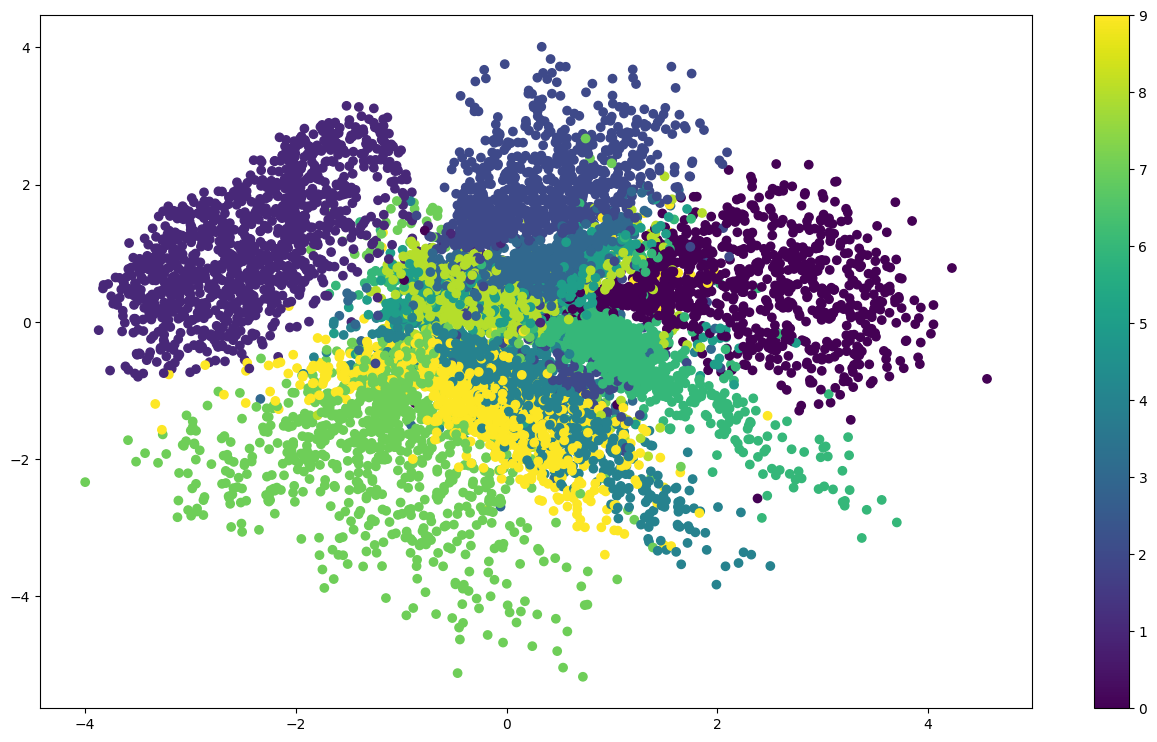

In [33]:
plt.figure(figsize=(16,9))
plt.scatter(values[:,0], values[:,1], c=targets)
plt.colorbar()
plt.plot()

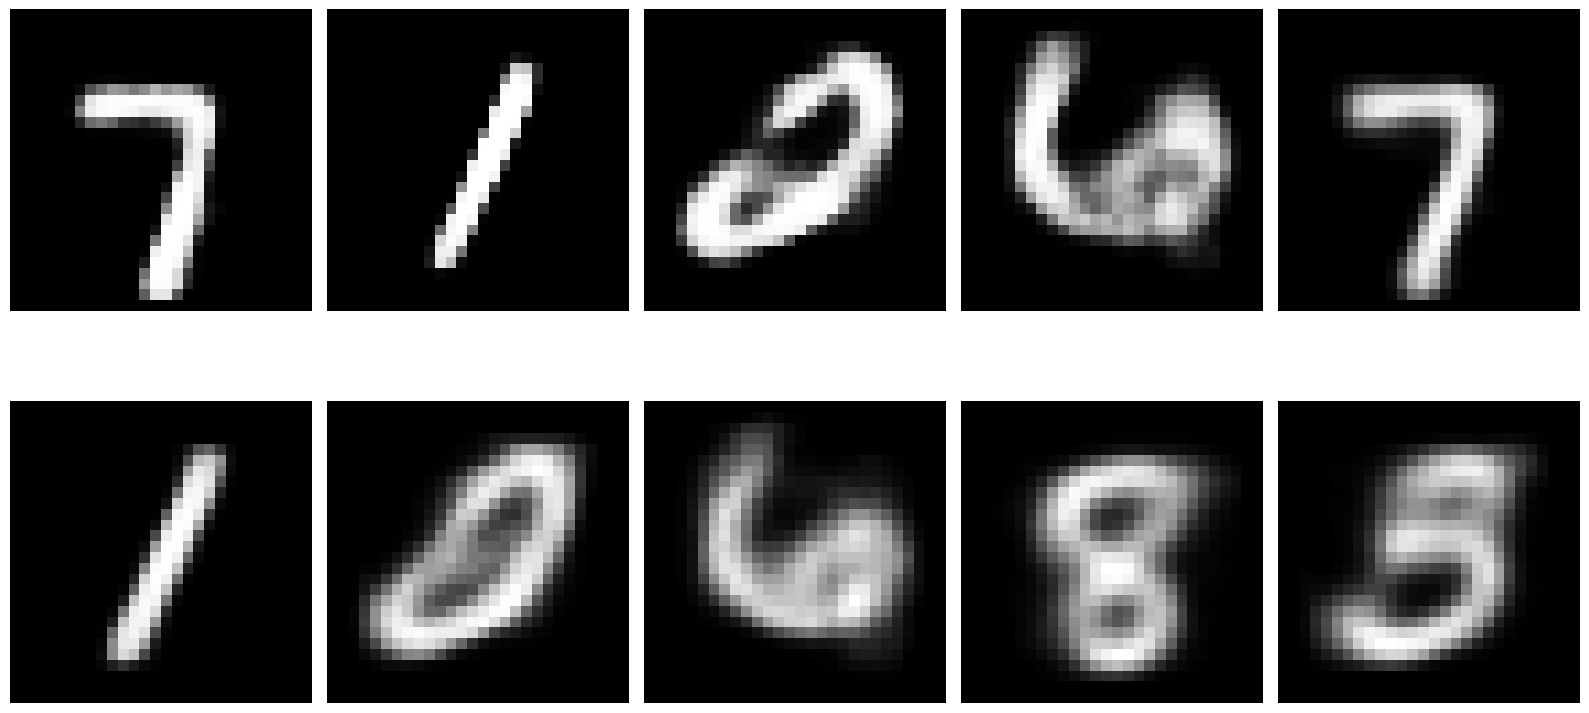

In [34]:
not_random_values = np.array([
  [-4, -4],
  [-4, 4],
  [4, 4],
  [4, -4],
  [-2, -2],
  [-2, 2],
  [2, 2],
  [2, -2],
  [0, 0],
  [1, 1]
])
to_restore = torch.FloatTensor(not_random_values).to(dev)
restored = vae.decoder(to_restore)

plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(restored[y * 5 + x].view(28,28).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

[]

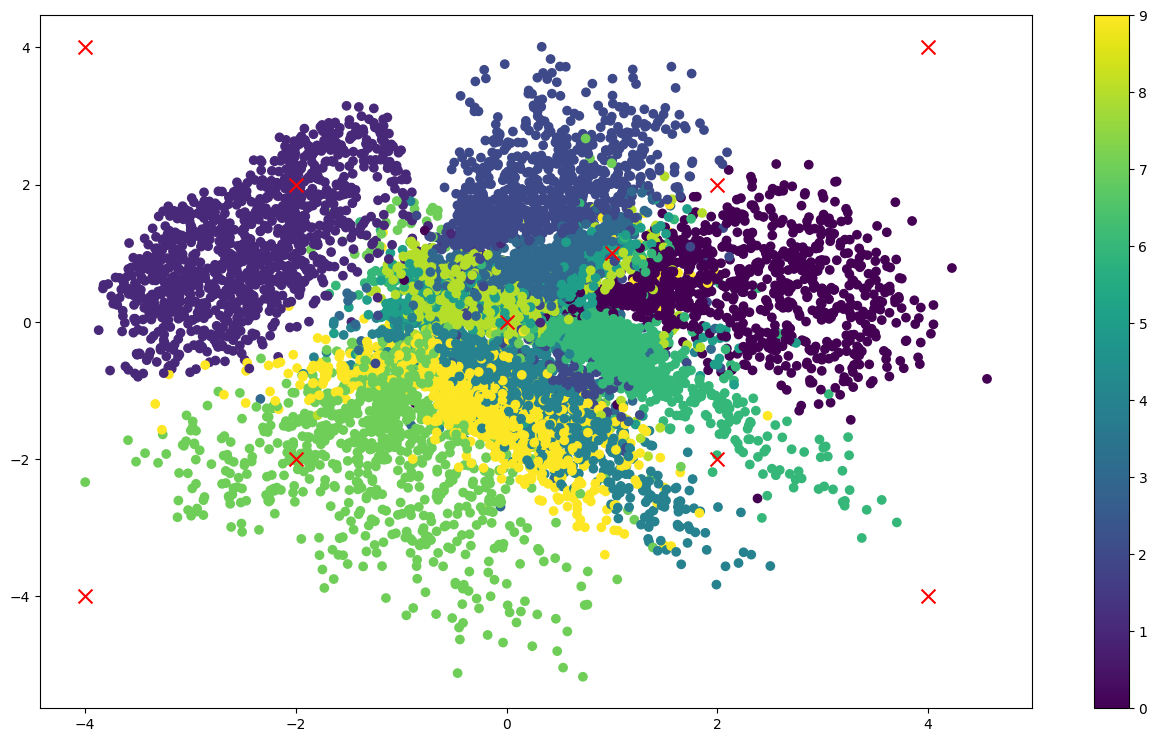

In [35]:
plt.figure(figsize=(16,9))
plt.scatter(values[:,0], values[:,1], c=targets)
plt.colorbar()
plt.scatter(not_random_values[:,0], not_random_values[:, 1], c='red', s=100, marker='x')
plt.plot()

## GAN

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = tv.datasets.MNIST(root='.', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
z_dim = 100
mnist_dim = 784

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(dev)
D = Discriminator(mnist_dim).to(dev)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(BATCH_SIZE, 1)
    x_real, y_real = torch.autograd.Variable(x_real.to(dev)), torch.autograd.Variable(y_real.to(dev))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    x_fake, y_fake = G(z), torch.autograd.Variable(torch.zeros(BATCH_SIZE, 1).to(dev))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    y = torch.autograd.Variable(torch.ones(BATCH_SIZE, 1).to(dev))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(dl):
        if len(x) != BATCH_SIZE:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/100]: loss_d: 0.991, loss_g: 2.497
[2/100]: loss_d: 0.638, loss_g: 5.166
[3/100]: loss_d: 1.054, loss_g: 2.137
[4/100]: loss_d: 0.882, loss_g: 1.881
[5/100]: loss_d: 0.872, loss_g: 1.721
[6/100]: loss_d: 0.758, loss_g: 3.443
[7/100]: loss_d: 0.662, loss_g: 2.984
[8/100]: loss_d: 0.648, loss_g: 2.769
[9/100]: loss_d: 0.446, loss_g: 3.236
[10/100]: loss_d: 0.519, loss_g: 3.014
[11/100]: loss_d: 0.524, loss_g: 3.054
[12/100]: loss_d: 0.417, loss_g: 3.481
[13/100]: loss_d: 0.491, loss_g: 3.195
[14/100]: loss_d: 0.499, loss_g: 3.104
[15/100]: loss_d: 0.588, loss_g: 3.348
[16/100]: loss_d: 0.554, loss_g: 2.771
[17/100]: loss_d: 0.412, loss_g: 3.226
[18/100]: loss_d: 0.536, loss_g: 3.075
[19/100]: loss_d: 0.508, loss_g: 3.102
[20/100]: loss_d: 0.446, loss_g: 3.029
[21/100]: loss_d: 0.440, loss_g: 3.236
[22/100]: loss_d: 0.484, loss_g: 3.224
[23/100]: loss_d: 0.460, loss_g: 3.286
[24/100]: loss_d: 0.511, loss_g: 3.112
[25/100]: loss_d: 0.516, loss_g: 3.095
[26/100]: loss_d: 0.484, loss_g: 2

In [ ]:
test_z = torch.autograd.Variable(torch.randn(10, z_dim).to(dev))
generated = G(test_z)

In [ ]:
generated.shape

torch.Size([10, 784])

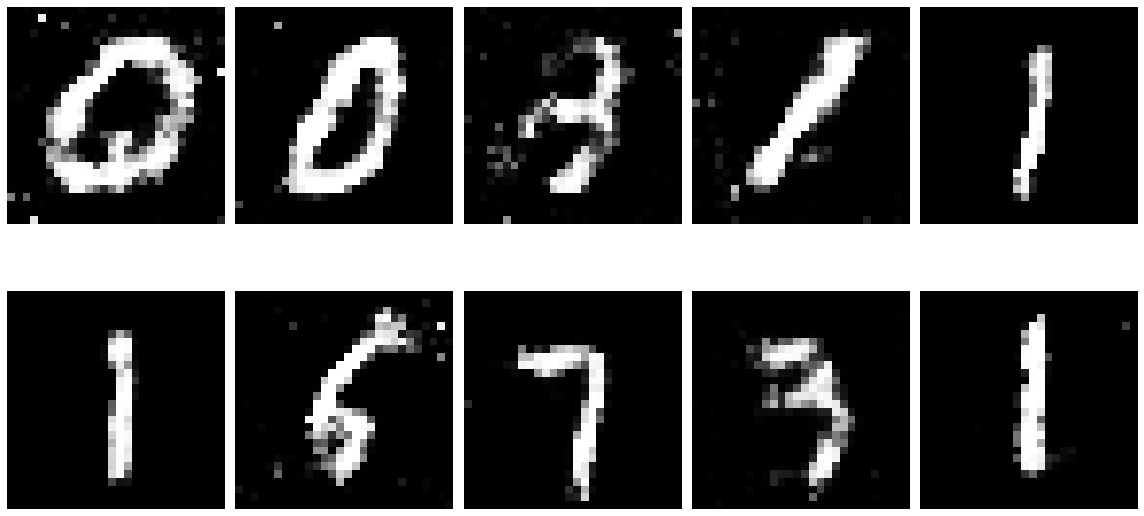

In [ ]:
plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(generated[y * 5 + x].view(28,28).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

## Домашнее задание

Сделайте генератор лиц аниме на основе датасета https://www.kaggle.com/soumikrakshit/anime-faces#10004.png